## Retrain

1. run inference (DONE - other notebook)
2. vectorize (DONE - this notebook)

#### to be done in this notebook: 
3. select random sample from inference (n = depending on how much we need to achieve accuracy)
4. plot over satellite image
5. ask user input
6. store user input

#### to be done in other notebook:

7. get pixel values 
8. retrain model, inputs:
    - existing weights and 
    - new pixel data from user input

repeat 

In [1]:
from skimage import filters, morphology
from rasterio import features 
from shapely.geometry import shape
from shapely import geometry
import itertools

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

In [2]:
# helper functions

def wgs2epsg(x,y):
    EPSG = int(32700-round((45+y)/90,0)*100+round((183+x)/6,0))
    UTM_EPSG_code = EPSG
    
    return UTM_EPSG_code


def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = all_rings #[g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
#             if pol['geometry']['type'] == 'MultiPolygon':
#                 for sub_pol in pol['geometry']['coordinates']:
#                     pol = sub_pol[0]
#                     shape_list.append(pol)
#             else:
                shape_list.append(pol)
            
    return shape_list

# load classification raster

In [3]:
# load classified rasters 

import rasterio 
import glob

from pprint import pprint

from shapely.ops import cascaded_union


name = ''

# find files in classification folder
raster_files_path = '../../data/raster_classifications/classification_{}*.tif'.format(name)
raster_files = glob.glob(raster_files_path)
file_path = raster_files[20]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files)
print('-------------------------------------')
print(file_path)

data = rasterio.open(file_path).read()
dataset = rasterio.open(file_path)

affine = dataset.meta['transform']
width = dataset.meta['width']
height = dataset.meta['height']

115
-------------------------------------
['../../data/raster_classifications/classification_Jakarta_287_pansharpen_True_2018-04-03_03:22_103001007C082C00.tif',
 '../../data/raster_classifications/classification_Jakarta_028_pansharpen_True_2018-09-13_03:30_1030010085B5FC00.tif',
 '../../data/raster_classifications/classification_Jakarta_651_pansharpen_True_2019-08-11_03:17_103001009861DE00.tif',
 '../../data/raster_classifications/classification_Medan_064_pansharpen_True_2020-03-03_04:05_10300100A367E500.tif',
 '../../data/raster_classifications/classification_Balikpapan_025_pansharpen_True_2019-03-10_02:44_103001008BD5FD00.tif',
 '../../data/raster_classifications/classification_Setu_rawa_indah_2018-09-13_03:30_1030010085B5FC00.tif',
 '../../data/raster_classifications/classification_Jakarta_380_pansharpen_True_2019-08-11_03:17_103001009861DE00.tif',
 '../../data/raster_classifications/classification_Balikpapan_015_pansharpen_True_2019-03-10_02:44_103001008BD5FD00.tif',
 '../../data/r

In [5]:
thresh = filters.threshold_otsu(data[0])

data_otsu_treshold = data[0] > thresh

water_data = data_otsu_treshold.astype('uint8')

In [9]:
# rescale values to 0 - 255 to use image processing algorithms
OldRange = (water_data.max() - water_data.min())  
NewRange = (0 - 255)  
NewValue = (((water_data - water_data.min()) * NewRange) / OldRange) + 0

water_data = NewValue.round().astype('uint8')

water_blurred = cv.medianBlur(water_data,15)

# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 500.

# From the image metadata, we can determine the area of a single grid cell
try: 
    cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
except: 
    cell_height_m = 0.40
    
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

# scikit-image modules for image science operators
from skimage import filters, morphology

# First, remove the small holes
water_cleaned = morphology.remove_small_holes(water_blurred, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

500.0 sq. m
3125 grid cells


/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


Text(0.5, 1.0, 'Cleaned Water Mask')

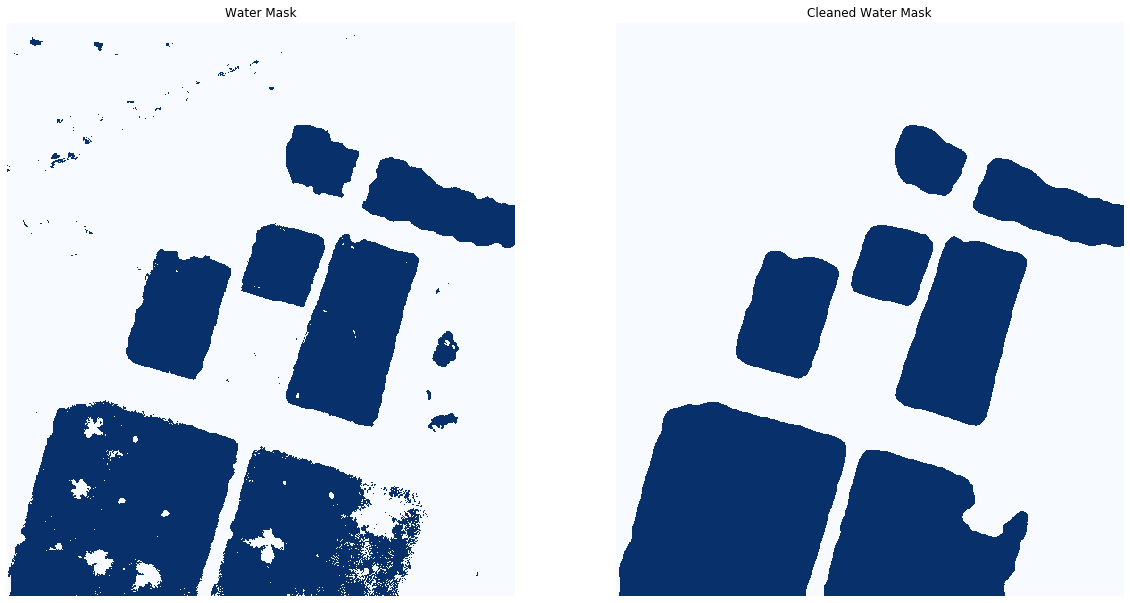

In [10]:
# # View the results
plt.figure(figsize=(20,15))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# # plt.imshow(rgb)
# plt.title("RGB")

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(data[0], vmin=0, vmax=1, cmap = 'Blues')
plt.title("Water Mask")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1, cmap = 'Blues')
plt.title("Cleaned Water Mask")

In [11]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(0.001) for g in water_lines]

# GLue it all together
detection = cascaded_union(water_lines)

In [12]:
import shapely.ops as ops
# setu_smooth = setu_wgs.simplify(0.00003)
detection_poly = ops.polygonize_full(detection)

detection_poly = cascaded_union(detection_poly)

buffer = 0# 1e-05

detection_poly_smooth = detection_poly.buffer(-buffer).buffer(buffer)

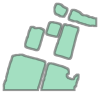

In [32]:
detection_poly_smooth

detection_poly = ops.polygonize_full(detection_poly_smooth)[0]

detection_poly

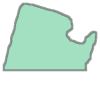

In [88]:
import random

sample = random.randint(0,len(detection_poly)) - 1 
detection_poly[sample]

# Get user input

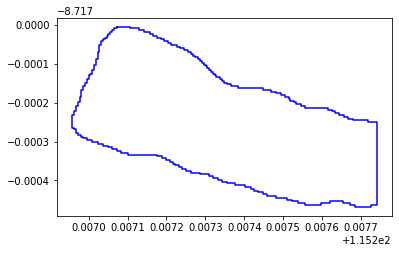

is it water?: y/nn
label is non water


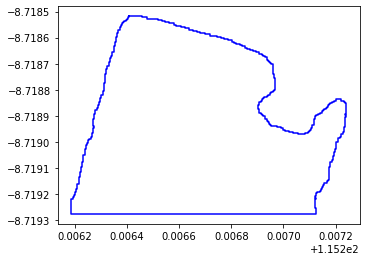

is it water?: y/ny
label is water


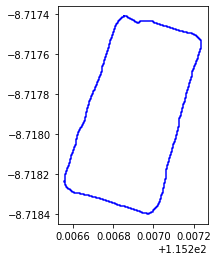

is it water?: y/ny
label is water


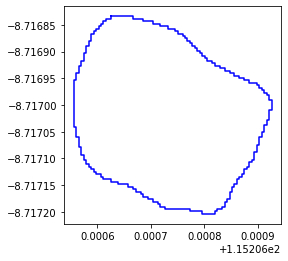

is it water?: y/nmn
label is non water


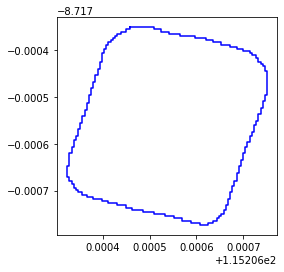

is it water?: y/nn
label is non water


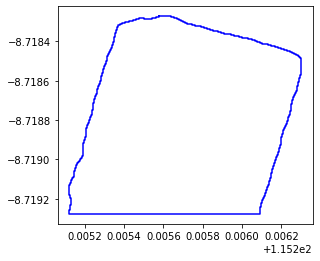

is it water?: y/ny
label is water


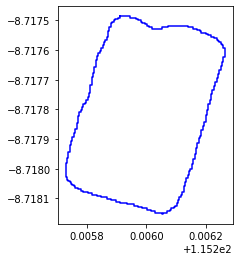

is it water?: y/nn
label is non water


In [102]:
df_user = []

for poly in detection_poly:
    
    x,y = poly.exterior.xy
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot(x,y, color = 'b')
#     plt.set_aspect('equal')
    plt.show()
    
    human_interaction = input('is it water?: y/n')
    
    if human_interaction == 'y': 
        
        df_user.append('water')
        print('label is water')
    else: 
        df_user.append('non_water')
        print('label is non water')
    

In [103]:
df_user

['non_water', 'water', 'water', 'non_water', 'non_water', 'water', 'non_water']

# write shape to file

In [23]:
import geopandas
from datetime import datetime
from datetime import timedelta

import numpy as np
import pandas as pd

import json

from pprint import pprint

In [24]:
def create_random_time_list(lenght, datetime):
    
    
    
    green_value_list = []
    date_time_green_list = []
        
    for i in range(lenght):

        new_time = date_time + timedelta(days = i/24 + np.random.normal(0,1,1)[0])
        date_time_green_list.append(new_time.strftime("%Y/%m/%d %H:%M:%S"))
        green_value_list.append(np.round(1.5 * i + np.random.normal(0,1,1)[0] * 2,2))

    green_over_time_pair_list = [ [x,str(y)] for x,y in zip(date_time_green_list, green_value_list)]
        
    json_list_green_over_time = json.dumps(green_over_time_pair_list)
    
    return json_list_green_over_time

In [33]:
geojson_poly = geopandas.GeoSeries([detection_poly]).__geo_interface__

In [36]:
df =  pd.DataFrame(columns = ['id', 
                              '_geojson',
                              'name',
                              'time', 
                              'water_area_over_time',
                              'green_over_time',
                              'sediment_load_over_time',
                              'parcel_overlap' ])

now = datetime.now() # current date and time

# 1967/08/01 10:33:50.47

date_time_poly = now
print("date and time:",date_time)

green_over_time_json_str = []



i_all = 0 

for geometry in geojson_poly['features'][0]['geometry']['geometries']:
    
    namegenerator
    
    str_list_coords = str([list(coords) for coords in geometry['coordinates'][0]])

    str_list_coords = '{"type":"Feature","geometry":{"type":"Polygon","coordinates":[%s]}}' % str_list_coords
    
    # print(geometry)
    
    name_waterbody = namegenerator.gen(separator = ' ')
    
    json_list_water_area_over_time = create_random_time_list(60, now)
    json_list_green_over_time = create_random_time_list(60, now)
    json_list_sediment_load_over_time = create_random_time_list(60, now)
    
    json_list_parcel_overlap = json.dumps({'hak_milik' :10, 'none':80,'bladiebla':20})

        
        
                

    
        
    df.loc[i_all] = [i_all, 
                     str_list_coords,
                     name_waterbody,
                     date_time_poly.strftime("%Y/%m/%d %H:%M:%S"), 
                     json_list_water_area_over_time,
                     json_list_green_over_time,
                     json_list_sediment_load_over_time,
                     json_list_parcel_overlap]
    i_all = i_all + 1

date and time: 2020-05-13 10:57:32.985858


In [37]:
df

,id,_geojson,name,time,water_area_over_time,green_over_time,sediment_load_over_time,parcel_overlap
0,0,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",stuffy auburn javanese,2020/05/13 10:58:45,"[[""2020/05/12 09:42:33"", ""-0.31""], [""2020/05/1...","[[""2020/05/13 22:30:54"", ""3.44""], [""2020/05/12...","[[""2020/05/14 01:54:00"", ""-0.65""], [""2020/05/1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
1,1,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",silly periwinkle bear,2020/05/13 10:58:45,"[[""2020/05/14 21:39:41"", ""-1.89""], [""2020/05/1...","[[""2020/05/13 08:09:17"", ""1.05""], [""2020/05/13...","[[""2020/05/14 00:24:05"", ""-2.01""], [""2020/05/1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
2,2,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",squirrely saffron goat,2020/05/13 10:58:45,"[[""2020/05/13 04:35:02"", ""-2.52""], [""2020/05/1...","[[""2020/05/13 01:04:23"", ""-1.25""], [""2020/05/1...","[[""2020/05/13 23:17:06"", ""-0.43""], [""2020/05/1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
3,3,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",whiny periwinkle bandicoot,2020/05/13 10:58:45,"[[""2020/05/13 22:21:38"", ""-0.61""], [""2020/05/1...","[[""2020/05/11 23:39:09"", ""-0.66""], [""2020/05/1...","[[""2020/05/11 22:38:25"", ""-1.27""], [""2020/05/1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
4,4,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",flabby aquamarine crane,2020/05/13 10:58:45,"[[""2020/05/14 05:11:16"", ""0.68""], [""2020/05/11...","[[""2020/05/13 00:09:17"", ""-5.6""], [""2020/05/13...","[[""2020/05/12 18:46:51"", ""1.45""], [""2020/05/13...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
5,5,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",pretty plum tarsier,2020/05/13 10:58:45,"[[""2020/05/14 17:37:23"", ""-0.18""], [""2020/05/1...","[[""2020/05/12 22:48:54"", ""-3.12""], [""2020/05/1...","[[""2020/05/13 00:42:06"", ""2.7""], [""2020/05/15 ...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"
6,6,"{""type"":""Feature"",""geometry"":{""type"":""Polygon""...",trippy cornflower terrier,2020/05/13 10:58:45,"[[""2020/05/13 11:56:06"", ""-2.13""], [""2020/05/1...","[[""2020/05/14 19:48:43"", ""-2.0""], [""2020/05/14...","[[""2020/05/13 21:39:58"", ""-1.77""], [""2020/05/1...","{""hak_milik"": 10, ""none"": 80, ""bladiebla"": 20}"


### write kepler.gl proof csv data to file

In [38]:
now = datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
file_location = '../../data/kepler_test_data/kepler_test_csv_%s.csv' % now

df.to_csv(file_location, index = False)

print('file written to: ', file_location)

file written to:  ../../data/kepler_test_data/kepler_test_csv_2020_05_13_10:59:20.csv
